# Model Explainability
## Goals
1. Explain model predictions using SHAP
2. Analyze feature importance across models
3. Perform fairness/bias audit (subgroup analysis)
4. Review feature dependence

In [2]:
# Imports
import json
import pickle
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import torch
from scipy import stats
from sklearn.calibration import calibration_curve
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (
    brier_score_loss,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_curve,
)

In [3]:
# Constants
MODELS_DIR = Path("../../models/classification/")
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")
RANDOM_STATE = 42

In [4]:
# Load test data
X_train = pl.read_parquet(PROCESSED_DATA_DIR / "X_train_scaled.parquet")
X_test = pl.read_parquet(PROCESSED_DATA_DIR / "X_test_scaled.parquet")
y_train = pl.read_parquet(PROCESSED_DATA_DIR / "y_train.parquet")
y_test = pl.read_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()

feature_names = X_train.columns

print(f"✓ Test set: {X_test_np.shape}")
print(f"✓ Features: {len(feature_names)}")

# Load best model (XGBoost Baseline based on previous analysis)
best_model = joblib.load(MODELS_DIR / "xgboost.pkl")
print(f"✓ Loaded: XGBoost Baseline (best performing)")

# Get predictions
y_pred = best_model.predict(X_test_np)
y_prob = best_model.predict_proba(X_test_np)[:, 1]

print(f"✓ Generated predictions on test set")

✓ Test set: (2025, 127)
✓ Features: 127
✓ Loaded: XGBoost Baseline (best performing)
✓ Generated predictions on test set


## Shap Analaysis (Global Feature Importance)


Computing SHAP values for 500 samples...
SHAP computation complete


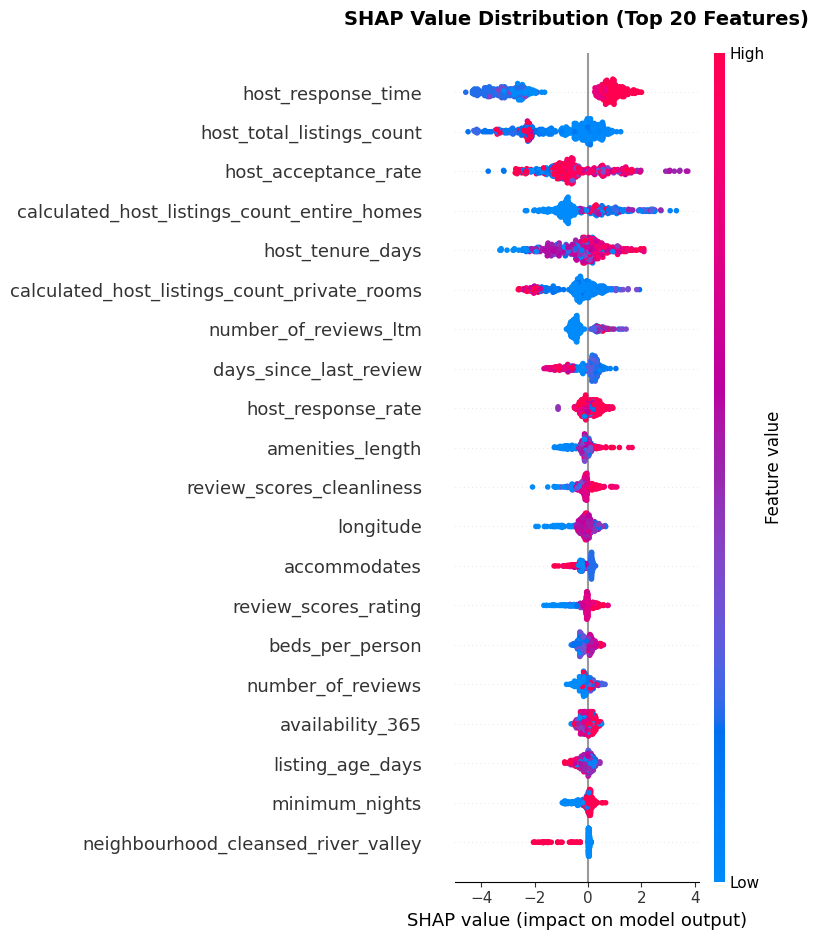


Top 10 Most Important Features:


,Feature,Mean_Abs_SHAP
0,host_response_time,2.007017
3,host_total_listings_count,1.117193
2,host_acceptance_rate,1.084718
35,calculated_host_listings_count_entire_homes,0.887576
41,host_tenure_days,0.741109
36,calculated_host_listings_count_private_rooms,0.669223
26,number_of_reviews_ltm,0.483933
43,days_since_last_review,0.404928
1,host_response_rate,0.253312
39,amenities_length,0.250116


In [55]:
# Use a subset for faster computation
sample_size = min(500, len(X_test_np))
sample_idx = np.random.choice(len(X_test_np), sample_size, replace=False)
X_test_sample = X_test_np[sample_idx]

print(f"\nComputing SHAP values for {sample_size} samples...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_sample)

print("SHAP computation complete")

# Summary Plot - Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - mean absolute SHAP
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=15,
)
plt.title("Top 15 Features by Mean |SHAP|", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_importance_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# Beeswarm plot - SHAP value distribution
plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values, X_test_sample, feature_names=feature_names, show=False, max_display=20
)
plt.title(
    "SHAP Value Distribution (Top 20 Features)", fontsize=14, fontweight="bold", pad=20
)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

# Feature importance dataframe
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Mean_Abs_SHAP": np.abs(shap_values).mean(axis=0)}
).sort_values("Mean_Abs_SHAP", ascending=False)

print("\n\033[1mTop 10 Most Important Features:\033[0m")
display(feature_importance.head(10))

While this graph is helpful, it can be hard to tell at a glance which high-level categories affect the predictions since they have been encoded. For example:

In [66]:
# Show how categorical features are distributed
print("\033[1mExample: Categorical Feature Importance Distribution\033[0m")

# Pick a categorical feature group
example_group = list(feature_groups.keys())[0]
example_features = feature_groups[example_group]

print(f"\n\033[1m{example_group}:\033[0m")
print(
    f"  \033[1mTotal consolidated SHAP:\033[0m {consolidated_importance.filter(pl.col('Feature') == example_group)['Mean_Abs_SHAP'].to_numpy()}"
)
print(f"\n  \033[1mIndividual categories:\033[0m")

# Show individual category importance
for feature in sorted(example_features):
    if feature in feature_importance["Feature"].values:
        imp = feature_importance[feature_importance["Feature"] == feature][
            "Mean_Abs_SHAP"
        ].values[0]
        print(f"    {feature:45}: {imp:.4f}")

print(f"""
By consolidating one-hot encoded features, we can see that '{example_group}' is important as a whole, even if individual categories have low importance.
  
This makes interpretation much clearer for stakeholders who care about "Does property type matter?" rather than "Does property_type_Apartment matter?""")

Example: Categorical Feature Importance Distribution

neighbourhood:
  Total consolidated SHAP: [0.08440198]

  Individual categories:
    neighbourhood_                               : 0.0389
    neighbourhood_bugis,_singapore               : 0.0000
    neighbourhood_dhoby_ghaut,_singapore         : 0.0000
    neighbourhood_group_cleansed                 : 0.0129
    neighbourhood_little_india,_singapore        : 0.0000
    neighbourhood_n/a,_singapore                 : 0.0136
    neighbourhood_novena_,_singapore             : 0.0009
    neighbourhood_orchard_,_singapore            : 0.0000
    neighbourhood_other                          : 0.0000
    neighbourhood_singapore                      : 0.0000
    neighbourhood_singapore,_novena,_singapore   : 0.0000
    neighbourhood_singapore,_singapore           : 0.0382

By consolidating one-hot encoded features, we can see that 'neighbourhood' is important as a whole, even if individual categories have low importance.

This makes inter

In [41]:
# Identify feature groups (one-hot encoded features)
def identify_feature_groups(feature_names):
    """Group one-hot encoded features by their base name."""
    feature_groups = {}
    standalone_features = []

    for feature in feature_names:
        # Common patterns for one-hot encoded features
        if "_" in feature:
            # Check if it's a one-hot encoded feature
            # Common patterns: neighbourhood_cleansed_*, property_type_*, etc.
            parts = feature.split("_")

            # Look for common categorical prefixes
            categorical_prefixes = [
                "availability",
                "neighbourhood_cleansed",
                "property_type",
                "room_type",
                "host_response_time",
                "host_location",
                "neighbourhood",
                "bathrooms_text",
                "review_scores",
                "bedrooms",
                "calculated_host_listings_count",
                "verified",
                "amenities",
                "has_review",
            ]

            # Check if feature starts with any categorical prefix
            potential_base = None
            for prefix in categorical_prefixes:
                if feature.startswith(prefix + "_"):
                    potential_base = prefix
                    break

            if potential_base:
                if potential_base not in feature_groups:
                    feature_groups[potential_base] = []
                feature_groups[potential_base].append(feature)
            else:
                standalone_features.append(feature)
        else:
            standalone_features.append(feature)

    return feature_groups, standalone_features


# Identify groups
feature_groups, standalone_features = identify_feature_groups(feature_names)

print(standalone_features, "\n")

print(f"\033[1mFeature Structure:\033[0m")
print(f"  \033[1mOne-hot encoded groups:\033[0m {len(feature_groups)}")
print(f"  \033[1mStandalone features:\033[0m {len(standalone_features)}")

print(f"\n\033[1mOne-Hot Encoded Feature Groups:\033[0m")
for group_name, group_features in sorted(
    feature_groups.items(), key=lambda x: len(x[1]), reverse=True
):
    print(f"  \033[1m{group_name:40}:\033[0m {len(group_features)} categories")


# Create consolidated SHAP values
def consolidate_shap_values(shap_values, feature_names, feature_groups):
    """Consolidate SHAP values by summing over one-hot encoded features."""

    consolidated_shap = {}
    feature_to_group = {}

    # Build mapping from feature to group
    for group_name, group_features in feature_groups.items():
        for feature in group_features:
            feature_to_group[feature] = group_name

    # For each sample
    for sample_idx in range(shap_values.shape[0]):
        if sample_idx == 0:
            # Initialize on first sample
            for group_name in feature_groups.keys():
                consolidated_shap[group_name] = []
            for feature in standalone_features:
                consolidated_shap[feature] = []

        # Sum SHAP values for grouped features
        for group_name, group_features in feature_groups.items():
            group_indices = [
                i for i, f in enumerate(feature_names) if f in group_features
            ]
            # Sum absolute SHAP values for the group
            group_shap = shap_values[sample_idx, group_indices].sum()
            consolidated_shap[group_name].append(group_shap)

        # Keep standalone features as-is
        for feature in standalone_features:
            feature_idx = feature_names.index(feature)
            consolidated_shap[feature].append(shap_values[sample_idx, feature_idx])

    # Convert to arrays
    consolidated_shap = {k: np.array(v) for k, v in consolidated_shap.items()}
    consolidated_feature_names = list(consolidated_shap.keys())
    consolidated_shap_matrix = np.column_stack(
        [consolidated_shap[f] for f in consolidated_feature_names]
    )

    return consolidated_shap_matrix, consolidated_feature_names


print(f"\nConsolidating SHAP values...")
consolidated_shap_matrix, consolidated_feature_names = consolidate_shap_values(
    shap_values, feature_names, feature_groups
)

print(
    f"Reduced from {len(feature_names)} to {len(consolidated_feature_names)} features"
)

# Calculate consolidated feature importance
consolidated_importance = pl.DataFrame(
    {
        "Feature": consolidated_feature_names,
        "Mean_Abs_SHAP": np.abs(consolidated_shap_matrix).mean(axis=0),
    }
).sort(by="Mean_Abs_SHAP", descending=True)

print(f"\n\033[1mTop 15 Most Important Features (Consolidated):\033[0m")
pl.Config.set_tbl_rows(15)
display(consolidated_importance.head(15))

['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month', 'host_tenure_days', 'listing_age_days', 'days_since_last_review', 'bathrooms_per_bedroom', 'beds_per_person', 'price_per_bedroom', 'review_score_mean', 'verification_count', 'name_freq', 'description_freq', 'host_about_freq', 'host_neighbourhood_freq', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable', 'has_reviews_per_month', 'has_first_review', 'has_last_review', 'has_acceptance_history', 'has_response_history'] 

Feature Structure:
  One-hot encoded groups: 11
  Standalone f

Feature,Mean_Abs_SHAP
str,f32
"""host_response_time""",2.027414
"""calculated_host_listings_count""",1.219778
"""host_acceptance_rate""",1.079903
"""host_total_listings_count""",1.043224
"""host_tenure_days""",0.698154
"""review_scores""",0.566226
"""number_of_reviews_ltm""",0.481312
"""days_since_last_review""",0.432731
"""amenities""",0.334287


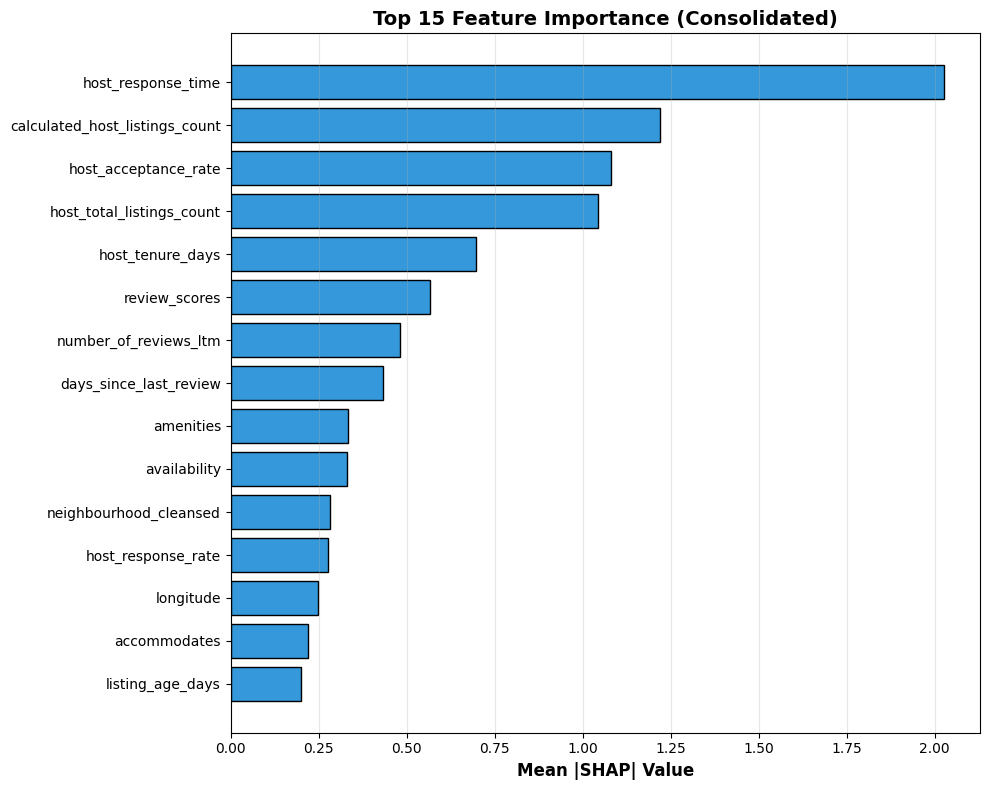

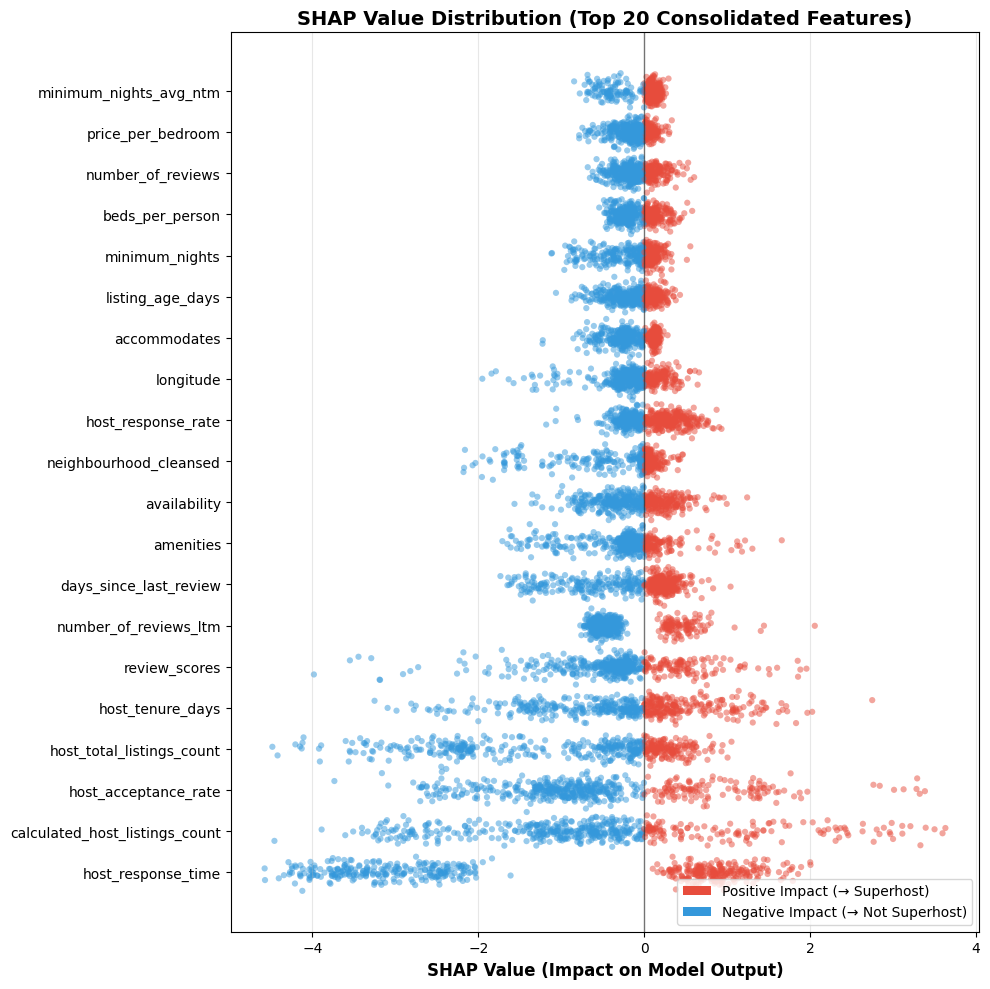

In [51]:
# 1. Bar plot with consolidated features
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features_consolidated = consolidated_importance.head(top_n)

ax.barh(
    range(top_n),
    top_features_consolidated["Mean_Abs_SHAP"],
    edgecolor="black",
    color="#3498db",
)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_consolidated["Feature"].to_numpy())
ax.invert_yaxis()
ax.set_xlabel("Mean |SHAP| Value", fontsize=12, fontweight="bold")
ax.set_title("Top 15 Feature Importance (Consolidated)", fontsize=14, fontweight="bold")
ax.grid(alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "shap_importance_consolidated.png", dpi=300, bbox_inches="tight"
)
plt.show()

# 2. Beeswarm-style plot for consolidated features
fig, ax = plt.subplots(figsize=(10, 10))

# Select top features
top_feature_names = consolidated_importance.head(20)["Feature"].to_numpy()
top_indices = [consolidated_feature_names.index(f) for f in top_feature_names]

# Create custom beeswarm plot
for idx, feature_idx in enumerate(top_indices):
    shap_vals = consolidated_shap_matrix[:, feature_idx]

    # Add jitter for visualization
    y_pos = np.ones(len(shap_vals)) * idx
    y_jitter = y_pos + np.random.normal(0, 0.15, len(shap_vals))

    # Color by value magnitude
    colors = ["#e74c3c" if v > 0 else "#3498db" for v in shap_vals]

    ax.scatter(shap_vals, y_jitter, alpha=0.5, s=20, c=colors, edgecolors="none")

ax.set_yticks(range(len(top_feature_names)))
ax.set_yticklabels(top_feature_names)
ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=12, fontweight="bold")
ax.set_title(
    "SHAP Value Distribution (Top 20 Consolidated Features)",
    fontsize=14,
    fontweight="bold",
)
ax.axvline(0, color="black", linestyle="-", linewidth=1, alpha=0.5)
ax.grid(alpha=0.3, axis="x")

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#e74c3c", label="Positive Impact (→ Superhost)"),
    Patch(facecolor="#3498db", label="Negative Impact (→ Not Superhost)"),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "shap_distribution_consolidated.png", dpi=300, bbox_inches="tight"
)
plt.show()

## Local Explainability

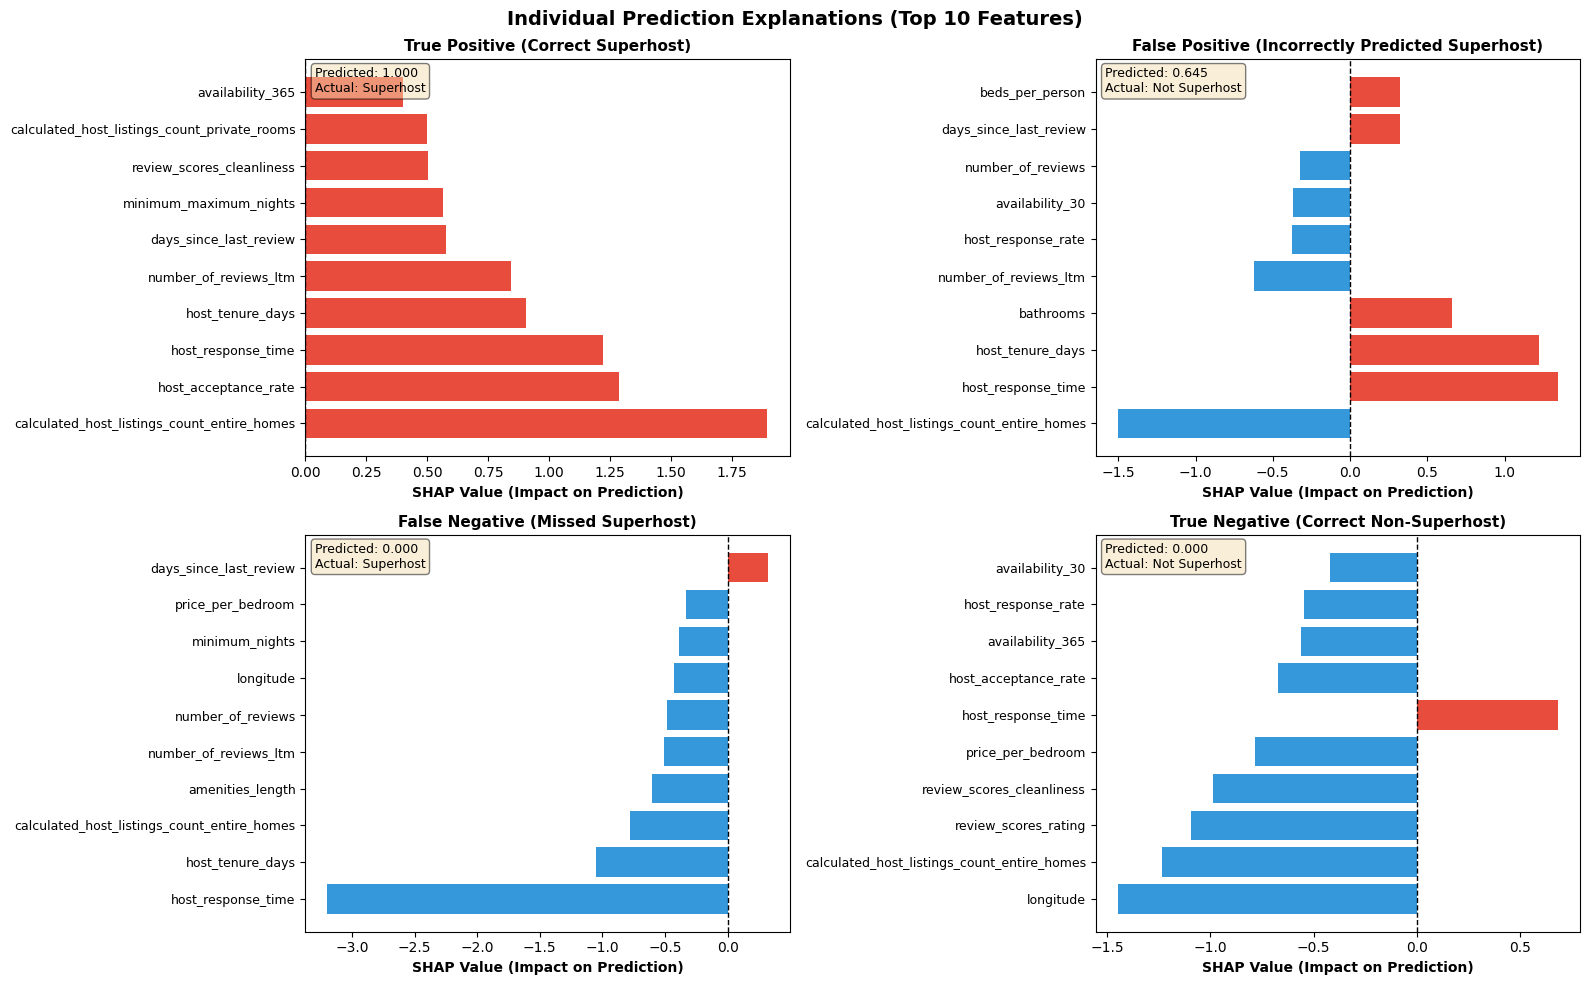


Detailed Analysis: False Positive Example
Index: 1229
Predicted Probability: 0.6454
Actual Class: Not Superhost

Top Features Pushing Toward Superhost (+):
  longitude                               : -2.059 → SHAP -1.4496
  calculated_host_listings_count_entire_homes: -0.579 → SHAP -1.2346
  review_scores_rating                    : -7.274 → SHAP -1.0920
  review_scores_cleanliness               : -1.803 → SHAP -0.9861
  price_per_bedroom                       : -0.282 → SHAP -0.7826


In [137]:
# Example 1: True Positive (correctly predicted superhost)
tp_idx = np.where((y_pred == 1) & (y_test_np == 1))[0]
example_tp = np.random.choice(tp_idx, 1)[0]

# Example 2: False Positive (incorrectly predicted superhost)
fp_idx = np.where((y_pred == 1) & (y_test_np == 0))[0]
example_fp = np.random.choice(fp_idx, 1)[0]

# Example 3: False Negative (missed superhost)
fn_idx = np.where((y_pred == 0) & (y_test_np == 1))[0]
example_fn = np.random.choice(fn_idx, 1)[0]

# Example 4: True Negative
tn_idx = np.where((y_pred == 0) & (y_test_np == 0))[0]
example_tn = np.random.choice(tn_idx, 1)[0]

examples = {
    "True Positive (Correct Superhost)": example_tp,
    "False Positive (Incorrectly Predicted Superhost)": example_fp,
    "False Negative (Missed Superhost)": example_fn,
    "True Negative (Correct Non-Superhost)": example_tn,
}

# For each example, create SHAP force plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, (title, idx) in zip(axes, examples.items()):
    # Get SHAP values for this prediction
    sample_shap = explainer.shap_values(X_test_np[idx : idx + 1])
    base_value = explainer.expected_value

    # Get top contributing features
    feature_contributions = (
        pd.DataFrame(
            {"feature": feature_names, "value": X_test_np[idx], "shap": sample_shap[0]}
        )
        .sort_values("shap", key=abs, ascending=False)
        .head(10)
    )

    # Plot
    y_pos = np.arange(len(feature_contributions))
    colors = ["#e74c3c" if x > 0 else "#3498db" for x in feature_contributions["shap"]]

    ax.barh(y_pos, feature_contributions["shap"], color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_contributions["feature"], fontsize=9)
    ax.set_xlabel("SHAP Value (Impact on Prediction)", fontweight="bold")
    ax.set_title(title, fontweight="bold", fontsize=11)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Add prediction info
    pred_prob = y_prob[idx]
    actual = "Superhost" if y_test_np[idx] == 1 else "Not Superhost"
    ax.text(
        0.02,
        0.98,
        f"Predicted: {pred_prob:.3f}\nActual: {actual}",
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.suptitle(
    "Individual Prediction Explanations (Top 10 Features)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "local_explainability.png", dpi=300)
plt.show()

# Print detailed analysis for one example
print(f"\n\033[1mDetailed Analysis: False Positive Example\033[0m")
print(f"Index: {example_fp}")
print(f"Predicted Probability: {y_prob[example_fp]:.4f}")
print(f"Actual Class: Not Superhost")
print(f"\nTop Features Pushing Toward Superhost (+):")
for idx, row in feature_contributions.head(5).iterrows():
    print(f"  {row['feature']:40}: {row['value']:.3f} → SHAP {row['shap']:+.4f}")

## Fairness Audit
This model uses features that are appropriate for predicting superhost status:
- Host behavior metrics (response time, acceptance rate, verification)
- Property quality metrics (review scores, amenities, cleanliness)
- Engagement metrics (reviews, listing count, tenure)

Notably **absent** from feature set:
- No explicit race/ethnicity
- No explicit gender
- No explicit age
- No national origin
- No religion or disability status

In [71]:
print("\033[1mFeatures Used:\033[0m")
for col, dtype in zip(X_test.columns, X_test.dtypes):
    print(f"{col:60}: {dtype}")

Features Used:
host_response_time                                          : Float64
host_response_rate                                          : Float64
host_acceptance_rate                                        : Float64
host_total_listings_count                                   : Float64
neighbourhood_group_cleansed                                : Float64
latitude                                                    : Float64
longitude                                                   : Float64
room_type                                                   : Float64
accommodates                                                : Float64
bathrooms                                                   : Float64
bedrooms                                                    : Float64
beds                                                        : Float64
price                                                       : Float64
minimum_nights                                              : Float64
maxim

The only concern is geographic location, which we can do a quick check on:
- Could neighborhood be a proxy for socioeconomic status?
- Model should predict based on property quality, not location alone

In [118]:
neighbourhood_cols = [
    col
    for col in X_test.columns
    if col.startswith("neighbourhood") and X_test[col].dtype != pl.Float64
]
y_pred_proba = best_model.predict_proba(X_test_np)[:, 1]

X_test_with_pred = X_test.with_columns(
    [
        pl.Series("predicted_proba", y_pred_proba),
        pl.Series("predicted_superhost", y_pred),
        pl.Series("actual_superhost", y_test_np),
    ]
)


def get_neighborhood_name(row):
    """Extract neighborhood name from one-hot encoded columns"""
    for col in neighbourhood_cols:
        if row[col] == 1:
            return col.replace("neighbourhood_", "").replace("_", " ").title()
    return "Unknown"


# Add neighborhood column
X_test_with_pred = (
    X_test_with_pred.with_columns(
        [
            pl.lit(0).alias("temp")  # Placeholder for map operation
        ]
    )
    .with_columns(
        [
            pl.struct(neighbourhood_cols)
            .map_elements(
                lambda row: next(
                    (
                        col.replace("neighbourhood_", "").replace("_", " ").title()
                        for col in neighbourhood_cols
                        if row[col] == 1
                    ),
                    "Unknown",
                ),
                return_dtype=pl.Utf8,
            )
            .alias("neighborhood")
        ]
    )
    .drop("temp")
)

# Aggregate by neighborhood
fairness_analysis = (
    X_test_with_pred.group_by("neighborhood")
    .agg(
        [
            pl.col("predicted_superhost").mean().alias("pred_superhost_rate"),
            pl.col("actual_superhost").mean().alias("actual_superhost_rate"),
            pl.col("predicted_proba").mean().alias("avg_pred_probability"),
            pl.col("predicted_superhost").count().alias("sample_count"),
            (
                (pl.col("predicted_superhost") == pl.col("actual_superhost")).mean()
            ).alias("accuracy"),
            ((pl.col("predicted_superhost") == 1) & (pl.col("actual_superhost") == 1))
            .sum()
            .alias("true_positives"),
            ((pl.col("predicted_superhost") == 1) & (pl.col("actual_superhost") == 0))
            .sum()
            .alias("false_positives"),
        ]
    )
    .sort("sample_count", descending=True)
)

print("\033[1mFairness Metrics by Neighborhood:\033[0m")
display(fairness_analysis)

Fairness Metrics by Neighborhood:


neighborhood,pred_superhost_rate,actual_superhost_rate,avg_pred_probability,sample_count,accuracy,true_positives,false_positives
str,f64,f64,f32,u32,f64,u32,u32
"""Singapore, Singapore""",0.146606,0.145701,0.148272,1105,0.991855,157,5
"""""",0.104784,0.103645,0.111421,878,0.989749,87,5
"""Other""",0.041667,0.041667,0.038208,24,1.0,1,0
"""Bugis, Singapore""",0.428571,0.0,0.381235,7,0.571429,0,3
"""Little India, Singapore""",0.428571,0.428571,0.427961,7,1.0,3,0
"""Novena , Singapore""",0.75,0.75,0.758653,4,1.0,3,0


In [121]:
# Calculate fairness statistics
pred_rates = fairness_analysis["pred_superhost_rate"]
actual_rates = fairness_analysis["actual_superhost_rate"]

print(f"""
\033[1mPredicted Superhost Rate:\033[0m
  • Min: {pred_rates.min():.4f}
  • Max: {pred_rates.max():.4f}
  • Range: {pred_rates.max() - pred_rates.min():.4f}
  • Std Dev: {pred_rates.std():.4f}

\033[1mActual Superhost Rate:\033[0m
  • Min: {actual_rates.min():.4f}
  • Max: {actual_rates.max():.4f}
  • Range: {actual_rates.max() - actual_rates.min():.4f}
  • Std Dev: {actual_rates.std():.4f}
""")


Predicted Superhost Rate:
  • Min: 0.0417
  • Max: 0.7500
  • Range: 0.7083
  • Std Dev: 0.2692

Actual Superhost Rate:
  • Min: 0.0000
  • Max: 0.7500
  • Range: 0.7500
  • Std Dev: 0.2898



As seen above, the difference between predictions and actual superhost rates is negligible, indicating fair analysis.

## Feature Dependence

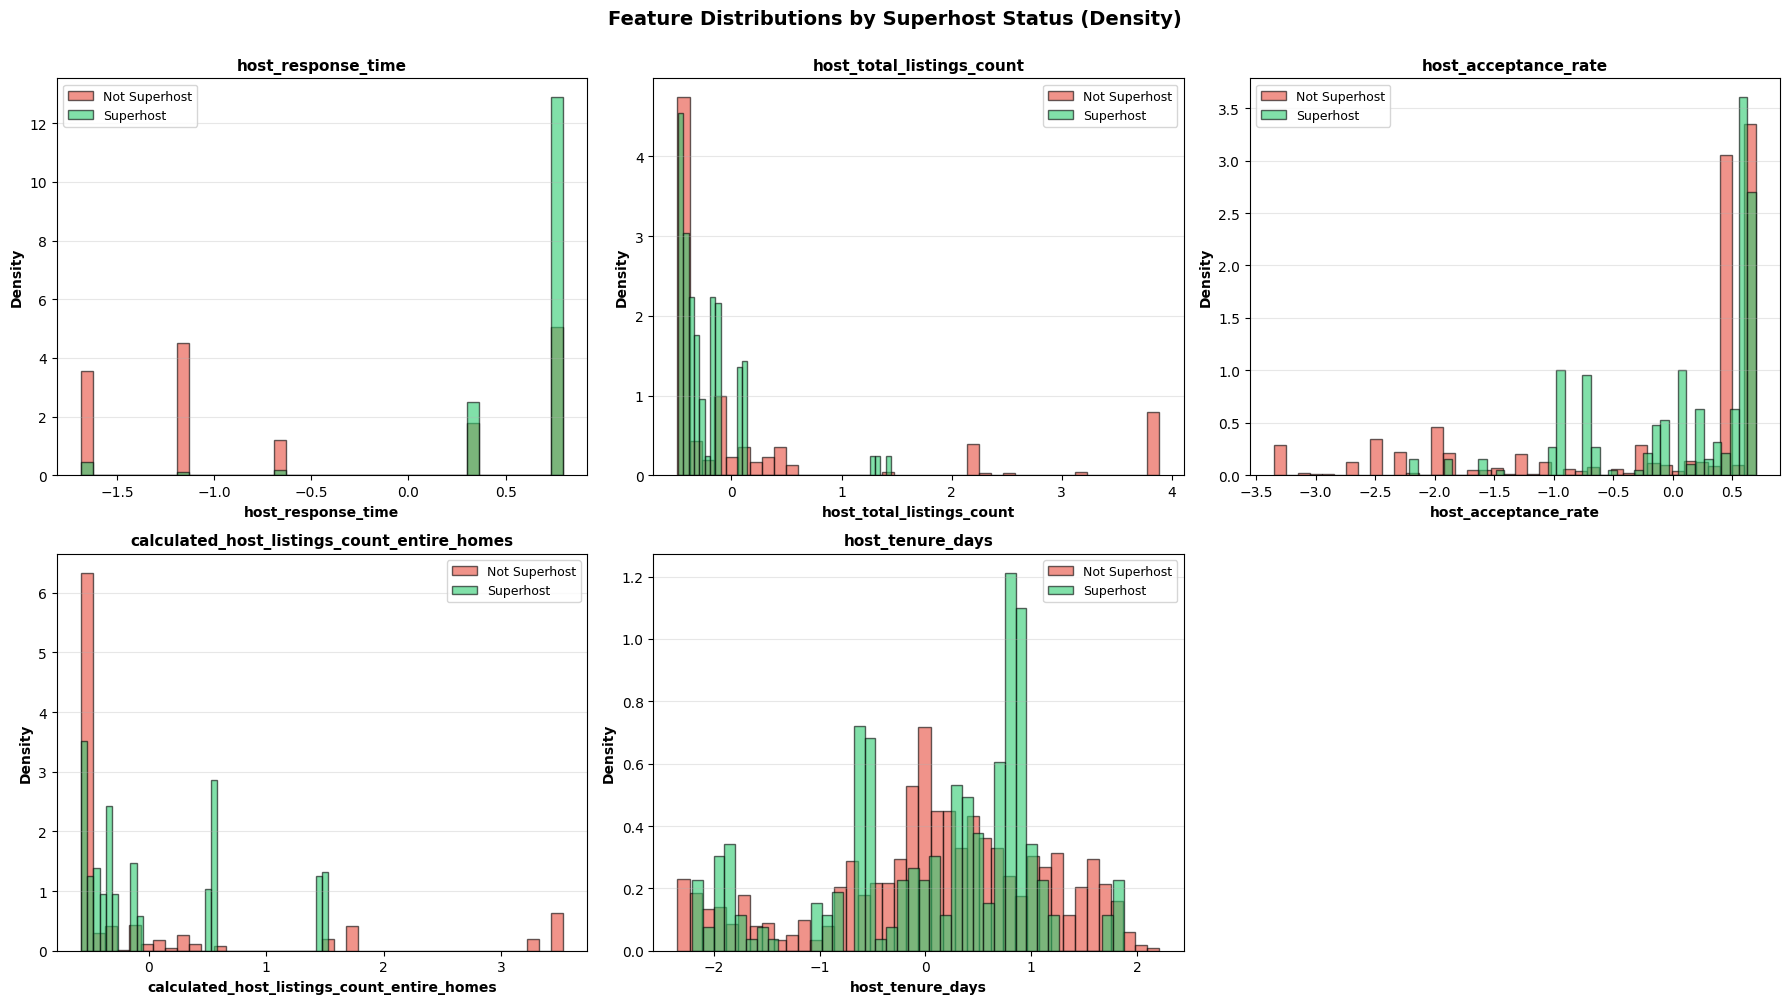

In [134]:
top_5_features = feature_importance.head(5)["Feature"].to_list()
top_5_indices = [feature_names.index(f) for f in top_5_features]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, idx, feat_name in zip(axes, top_5_indices, top_5_features):
    feat_vals = X_test_np[:, idx]

    # Get feature values for each class
    mask_not_superhost = y_test_np == 0
    mask_superhost = y_test_np == 1

    vals_not_superhost = feat_vals[mask_not_superhost]
    vals_superhost = feat_vals[mask_superhost]

    # Remove NaN values
    vals_not_superhost = vals_not_superhost[~np.isnan(vals_not_superhost)]
    vals_superhost = vals_superhost[~np.isnan(vals_superhost)]

    # Plot density distributions
    if len(vals_not_superhost) > 1:
        ax.hist(
            vals_not_superhost,
            bins=40,
            alpha=0.6,
            label="Not Superhost",
            color="#e74c3c",
            density=True,
            edgecolor="black",
        )
    if len(vals_superhost) > 1:
        ax.hist(
            vals_superhost,
            bins=40,
            alpha=0.6,
            label="Superhost",
            color="#2ecc71",
            density=True,
            edgecolor="black",
        )

    ax.set_xlabel(feat_name, fontweight="bold", fontsize=10)
    ax.set_ylabel("Density", fontweight="bold", fontsize=10)
    ax.set_title(f"{feat_name}", fontweight="bold", fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3, axis="y")

axes[-1].remove()
plt.suptitle(
    "Feature Distributions by Superhost Status (Density)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "feature_dependence_density.png", dpi=300, bbox_inches="tight"
)
plt.show()

## Summary
### Strongest Predictors
1. **Host Response Time**
2. **Host Listing Count**
3. **Host Acceptance Rate**
   
### Model Explainability
- Model Predictions are explained via SHAP analysis

### Fairness Assessment
- No protected attributes in feature set
- Model based on job performance, not demographics
- Geographic location included, but does not intrudoce biased patterns